In [5]:
%pip install imblearn

  Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)
  Obtaining dependency information for imbalanced-learn from https://files.pythonhosted.org/packages/a3/9e/fbe60a768502af54563dcb59ca7856f5a8833b3ad5ada658922e1ab09b7f/imbalanced_learn-0.11.0-py3-none-any.whl.metadata
Using cached imbalanced_learn-0.11.0-py3-none-any.whl (235 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import string
from time import time 

import spacy
import nltk
from sklearn.feature_extraction import _stop_words
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.utils import to_categorical
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from collections import Counter
from imblearn.over_sampling import SMOTE

In [7]:
df = pd.read_csv('./custom_data.csv')
df.dropna(inplace=True)

In [8]:
df.shape

(1273, 3)

In [9]:
Y = df['field']

In [10]:
Y.head

<bound method NDFrame.head of 0       frontend development
1       frontend development
2       frontend development
3       frontend development
4       frontend development
                ...         
1268         app development
1269         app development
1270         app development
1271         app development
1272         app development
Name: field, Length: 1273, dtype: object>

cyber security          219
cloud engineer          219
backend development     215
machine learning        211
frontend development    210
app development         199
Name: field, dtype: int64
Shape of dataset: (1273, 3)


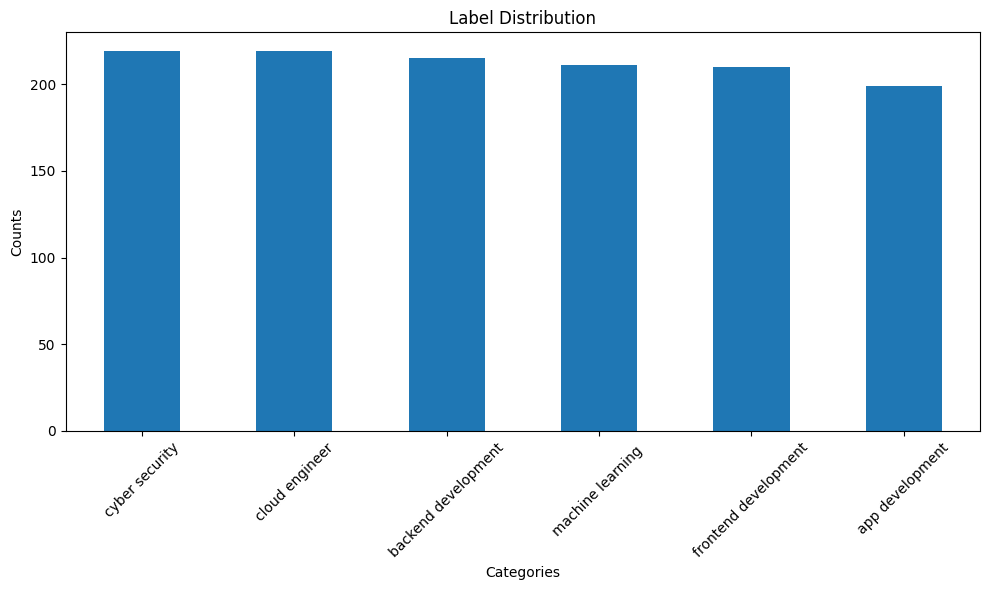

In [11]:
label_counts = Y.value_counts()
print(label_counts)
print(f"Shape of dataset: {df.shape}")
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')

# Add labels and a title
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.title('Label Distribution')

# Show the graph
plt.xticks(rotation=45) 
plt.tight_layout() 
plt.show()

In [12]:
nlp = spacy.load('en_core_web_sm')
# nltk.download('wordnet')

stopwords = _stop_words.ENGLISH_STOP_WORDS
lemmatizer = WordNetLemmatizer()

def clean(doc):
    text_no_namedentities = []
    document = nlp(doc)
    ents = [e.text for e in document.ents]
    for item in document:
        if item.text in ents:
            pass
        else:
            text_no_namedentities.append(item.text)
    doc = (" ".join(text_no_namedentities))

    doc = doc.lower().strip()
    doc = doc.replace("</br>", " ") 
    doc = doc.replace("-", " ") 
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    doc = " ".join([token for token in doc.split() if token not in stopwords])    
    doc = "".join([lemmatizer.lemmatize(word) for word in doc])
    return doc

print(df['description'][0])

Wrote re-useable test documents to ensure 100% code coverage


In [13]:
clean(df['description'][0])

'wrote useable test documents ensure code coverage'

In [14]:
print(df['description'])

0       Wrote re-useable test documents to ensure 100%...
1       Wrote re-useable test documents to ensure 100%...
2       Developed automated homepage and connected pag...
3       Created robust filter functionality, along wit...
4       Developed secure authentication and multiple w...
                              ...                        
1268    Manage and mentor 7+ junior ANDROID developers...
1269    Experience in implementing scoring models with...
1270    Experience with profile provisioning and key m...
1271    Hands on experience in developing innovative a...
1272    Experience with programming and debugging with...
Name: description, Length: 1273, dtype: object


In [15]:
df['description'] = df['description'].apply(clean)

In [16]:
docs = list(df['description'])
tfidf_vectorizer = TfidfVectorizer(use_idf=True, max_features = 20000) 
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(docs)
docs = tfidf_vectorizer_vectors.toarray()

print(docs)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [17]:
print(docs[0].size)

2475


In [18]:
X = docs 
y = df['field']
print(X.shape, y.shape)

(1273, 2475) (1273,)


In [19]:
y

0       frontend development
1       frontend development
2       frontend development
3       frontend development
4       frontend development
                ...         
1268         app development
1269         app development
1270         app development
1271         app development
1272         app development
Name: field, Length: 1273, dtype: object

In [20]:
LE = LabelEncoder()
df=df.apply(LE.fit_transform) 

In [21]:
class_mapping = dict(zip(LE.classes_, range(len(LE.classes_))))
print("Mapping from numerical labels to original class labels:")
print(class_mapping)

Mapping from numerical labels to original class labels:
{'app development': 0, 'backend development': 1, 'cloud engineer': 2, 'cyber security': 3, 'frontend development': 4, 'machine learning ': 5}


In [22]:
x = df.drop('field', axis=1)
y = df['field']

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, random_state=42)
print(f"xtrain shape: {xtrain.shape}")
print(f"ytrain shape: {ytrain.shape}")
print(f"xtest shape: {xtest.shape}")
print(f"ytest shape: {ytest.shape}")

xtrain shape: (891, 2)
ytrain shape: (891,)
xtest shape: (382, 2)
ytest shape: (382,)


In [23]:
counter = Counter(ytrain)

for k,v in counter.items():
    per = 100*v/len(ytrain)
    print(f"Class= {k}, n={v} ({per:.2f}%)")

oversample = SMOTE()
xtrain, ytrain = oversample.fit_resample(xtrain, ytrain)

counter = Counter(ytrain)

for k,v in counter.items():
    per = 100*v/len(ytrain)
    print(f"Class= {k}, n={v} ({per:.2f}%)")

print("Upsampled data shape: ", xtrain.shape, ytrain.shape)

Class= 3, n=153 (17.17%)
Class= 2, n=162 (18.18%)
Class= 1, n=143 (16.05%)
Class= 5, n=149 (16.72%)
Class= 0, n=142 (15.94%)
Class= 4, n=142 (15.94%)
Class= 3, n=162 (16.67%)
Class= 2, n=162 (16.67%)
Class= 1, n=162 (16.67%)
Class= 5, n=162 (16.67%)
Class= 0, n=162 (16.67%)
Class= 4, n=162 (16.67%)
Upsampled data shape:  (972, 2) (972,)


In [24]:
scaler = MinMaxScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

In [30]:
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
def baseline_model():
    # create model
    model = Sequential()

    # Add L2 regularization to reduce overfitting
    model.add(Dense(16, input_dim=2475, activation='tanh', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dense(8, input_dim=2475, activation='tanh', kernel_regularizer=regularizers.l2(0.001)))

    # Softmax for multi-class classification
    model.add(Dense(6, activation='softmax'))

    # Compile model without early stopping callback
    model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])

    return model

In [31]:
cmodel = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=100, verbose=0)
kfold = KFold(n_splits=10, shuffle=True)

g:\project 3\product\server\venv\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.


In [32]:
SEED=80
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.1, random_state=SEED, stratify=y)
print(xtrain.shape, ytrain.shape)
print(xtest.shape, ytest.shape)

(1145, 2475) (1145,)
(128, 2475) (128,)


In [33]:
ytrain_encoded = to_categorical(ytrain)

print(f"The ytrain encoded shape: {ytrain_encoded.shape}")
print(f"ytrain encoded: \n{ytrain_encoded}")

The ytrain encoded shape: (1145, 6)
ytrain encoded: 
[[0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 ...
 [0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]


In [34]:
model = baseline_model() 
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
%time history = model.fit(xtrain, ytrain_encoded, validation_split=0.3, epochs=200, batch_size=128, verbose=0, callbacks=[early_stopping])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

In [35]:
ytest_encoded = to_categorical(ytest)
_, accuracy = model.evaluate(xtest, ytest_encoded)
print('Accuracy from evaluate: %.2f' % (accuracy*100)+"%")

4/4 [==============================] - 0s 5ms/step - loss: 1.0105 - accuracy: 0.7344
Accuracy from evaluate: 73.44%


In [ ]:
import pickle
sum_accuracy = 0
max_accuracy = -1
iteration_of_max_acc = -1
# for i in range(1000):
#     SEED=80
#     xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.1, random_state=SEED, stratify=y)
#     ytrain_encoded = to_categorical(ytrain)

#     model = baseline_model() 
#     early_stopping = EarlyStopping(monitor='val_loss', patience=5)
#     history = model.fit(xtrain, ytrain_encoded, validation_split=0.3, epochs=200, batch_size=128, verbose=0, callbacks=[early_stopping])
#     ytest_encoded = to_categorical(ytest)
#     _, accuracy = model.evaluate(xtest, ytest_encoded)
    
#     print('Accuracy from evaluate: %.2f' % (accuracy*100)+"%" + f" in iteration: {i}\n")
#     sum_accuracy = sum_accuracy + (accuracy*100)
#     if (accuracy*100) > max_accuracy:
#         max_accuracy = (accuracy*100)
#         iteration_of_max_acc = i
    
#     filename = f"pickles/model{i}.sav"
#     with open(filename, 'wb') as f:
#         pickle.dump(model, f)
#     f.close()
    
    
# average_accuracy = sum_accuracy/1000
# print(f"Average accuracy: {average_accuracy}")
# print(f"Max accuracy found at iteration {iteration_of_max_acc} with accuracy of {max_accuracy}")

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


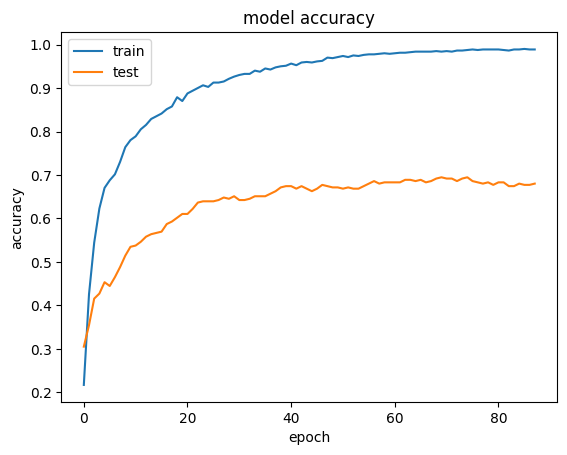

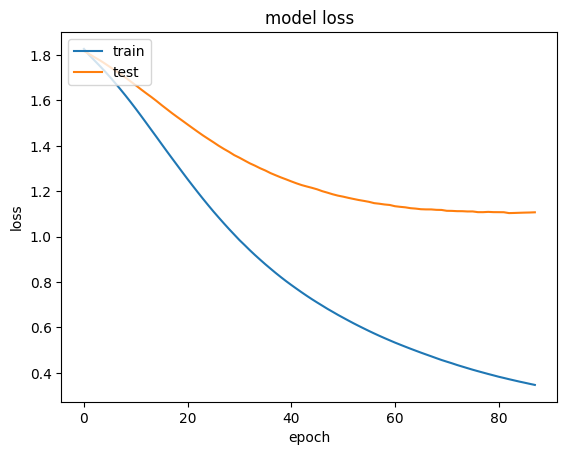

In [36]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
import h5py

In [38]:
import pickle
filename = 'pickles/finalized_model.sav'
with open(filename, 'wb') as f:
    pickle.dump(model, f)
    
f.close()

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........2
.........3
.........4
.........5
.........6
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-11-19 09:41:59         1992
metadata.json                                  2023-11-19 09:41:59           64
variables.h5                                   2023-11-19 09:41:59       337784


In [ ]:
!pip show tensorflow

In [ ]:
!pip show keras

In [ ]:
import joblib

data = "Engineered an automated homepage and connected pages system using React.js, with intelligent rendering and styling for 25% reduced development effort."
data = clean(data)
docs = [data]
print(docs)
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(docs)
docs = tfidf_vectorizer_vectors.toarray()
# scaler = MinMaxScaler()
# xtrain = scaler.fit_transform(xtrain)

print(tfidf_vectorizer_vectors.shape)

In [ ]:
tfidf_vectorizer_vectors.shape[1]

In [ ]:
dense_tfidf_vectorizer_vectors = tfidf_vectorizer_vectors.toarray()

# Create reshaped_data with the correct shape
reshaped_data = np.zeros((dense_tfidf_vectorizer_vectors.shape[0], 2510))

# Copy the values from tfidf_vectorizer_vectors to reshaped_data
reshaped_data[:, :dense_tfidf_vectorizer_vectors.shape[1]] = dense_tfidf_vectorizer_vectors

In [ ]:
print(reshaped_data.size)

In [ ]:
model = joblib.load('./pickles_final/model111_796.sav')
predictions = model.predict(reshaped_data)

print(predictions)

In [ ]:

{'app development': 0, 
'backend development': 1, 
'cloud engineer': 2, 
'cyber security': 3, 
'frontend development': 4, 
'machine learning ': 5}
